## ML Basics: Bayesian Inference

#### Introduction

This is the second of a set of little blog-style post that I'm creating to get a better grasp on machine learning concepts. I'm mainly following the book "Deep Learning" by Ian Goodfellow, Yoshua Bengio and Aaron Courville [1], but if any other resources are used I'll be citing them underneath this introduction. While alot of these examples are going to be ones I take from [1] I think sometimes it helps to provide some context or explanation to an equation which is what I'm going to try to do throughought this series. If you see any mistakes please feel free to email me at adibfixeshismistakes@gmail.com.


#### Additional References
https://www.probabilisticworld.com/frequentist-bayesian-approaches-inferential-statistics/ [2]

https://towardsdatascience.com/probability-concepts-explained-bayesian-inference-for-parameter-estimation-90e8930e5348 [3] (Jonny Brooks-Bartlett)

#### Frequentist vs Bayesian statistics

Frequentist statistics assign probabilities to repeatable random events. The probabilities of these events are equal to their long-term frequency of occurance. With that definition one-off events can't be assigned a probability since we dont actually have any idea how often they will occur from just one occurance. Bayesian statistics try to use probabilities to represent the amount of uncertainty in a given event and then updating this estimation using the observed data (with the likelihood).

Suppose we take the estimation of some parameter in a probability model as an example. The frequentist approach is to assume that the parameter we're trying to estimate has some fixed value, so there cant be any probabilities assigned to the value of the parameter being equal to any given value, all we can do is to collect some data and estimate the parameter based on the value that is most likeliy to produced the training data. Alternatively the Bayesian perspective accepts that the parameter is fixed an unknown but there can still be a probability distribution defined over all the possible values of the mean. The sample data is used to tap into this distribution and pick the best estimate for the parameter. This is done using Bayes' Theorem.

$$
\begin{aligned}
P(Parameter | Data) = \frac{P(Data | Parameter) P(Parameter)}{P(Data)}
\end{aligned}
$$

$P(Parameter)$ is known as the **prior probability**, the assumed distribution of the parameter we're trying to estimate **prior to knowing anything about the data**. $P(Data|Parameter)$ is the **likelihood of observing a given data set at a particular value of the parameter**. $P(Parameter | Data)$ is known as the **posterior probability** its **the probability that the selected value for our parameter is the true value for the data distribution**. This is similar to the confidence intervals that can be generated by utilizing the frequentist approach, but instead of providing a range of values for an expected level of certainty we're extracting the amount of certainty that we can expect for a given estimate. $P(Data)$ is known as **the evidence**, the probability of the data being observed, **its actually a constant value rather than a distribution used to make sure that the posterior probability is an actual probability distribution that integrates to 1**.

Since we're only interested in the peak of the posterior probability for parameter estimation we can represent this estimator as a proportionality statement and remove the need to consider $P(Data)$. This only works because we're only interested in the peak 

$$
\begin{aligned}
P(Parameter | Data) \propto P(Data | Parameter) P(Parameter)
\end{aligned}
$$

Interestingly the likelihood function used in the frequentist approach is present in the Bayesian equation as well, but its scaled based on the suspected distributions of the parameter and the data. Of course, these estimations for the prior probability and the evidence could be completely wrong so its important to pick these based on educated guesses or some domain specific knowledge.

Revisiting the toy example that I used in my maximum likelihood estimation post, lets assume we have some gaussian distributed random variable $X$ and we're trying to estimate its mean $\mu$. We collect some i.i.d data set $X^m = {X_1=x_1,X_2=x_2,...X_n=x_n}$.

$$
\begin{aligned}
X &\sim N(x; \mu, \sigma^2)\\
P(X_1=x_1, X_2=x_2,...X_n=x_n) &= (\frac{1}{\sqrt{2\pi\sigma^2}})^n\exp^{-\frac{\sum^n_{i=1}(x_i - \mu)^2}{2\sigma^2}}
\end{aligned}
$$

Aditionally lets use a gaussian prior for the probability distribution of $\mu$, centered at some value $\mu'$ with variance $\sigma'^2$.

$$
\begin{aligned}
\mu &\sim N(x; \mu', \sigma'^2)\\
\mu &= \frac{1}{\sqrt{2\pi\sigma'^2}}\exp^{-\frac{\sum^k_{i=1}(\mu_i - \mu')^2}{2\sigma'^2}}
\end{aligned}
$$

This describes the probability distribution for some set of K values $\mu_K = {\mu_1, \mu_2...\mu_k}$

Now solving for the proportionality statement for the posterior probability we get

$$
\begin{aligned}
P(\mu = \mu_k | X) &\propto P(X | \mu_k)P(\mu_k)\\
&= (\frac{1}{\sqrt{2\pi\sigma^2}})^n\exp^{-\frac{\sum^n_{i=1}(x_i - \mu_k)^2}{2\sigma^2}}\frac{1}{\sqrt{2\pi\sigma'^2}}\exp^{-\frac{(\mu_k - \mu')^2}{2\sigma'^2}}\\
&= (\frac{1}{2\pi\sqrt{\sigma}})^n(\frac{1}{\sqrt{\sigma'^2}})\exp{\frac{\sum^n_{i=1}{(x_i-\mu_k)^2} - (\mu_k - \mu')^2}{4\sigma^2 \sigma'^2}}
\end{aligned}
$$

Lets take a look at this in code.

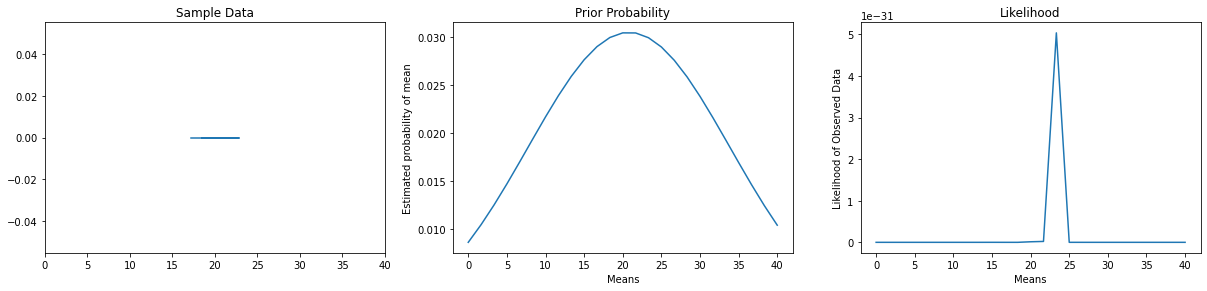

In [53]:
%matplotlib inline
import functools
import matplotlib.pyplot as plt
import numpy as np

def gaussian(mean, variance, x):
    '''Samples a gaussian distribution with specified mean and variance'''
    return (1 / np.sqrt((2 * np.pi * variance))) * np.exp(-0.5 * (((x - mean)**2)/(variance)))

def integrate(f, xaxis, dx):
    '''Calculate the midpoint Riemann sum integral approximation for function f'''
    mid_points = (xaxis[:-1] + xaxis[1:]) / 2
    return mid_points, np.cumsum(f(mid_points)) * dx

def gaussian_sampling(num_samples, mean, variance):
    '''Generates an array of random gaussian distributed points with a parametric distribution
       defined by mean and variance'''
    samples = np.random.rand(num_samples)
    xmin = 0.05 * mean
    xmax = 2.05 * mean
    linear_space = np.linspace(xmin, xmax, num_samples)
    dx = (xmax - xmin) / num_samples
    integral_x, integral_y = integrate(functools.partial(gaussian, mean, variance), linear_space, dx)
    points = []
    for sample in samples:
        try:
            points.append(integral_x[(np.where(integral_y >= sample))[0][0]])
        except IndexError:
            # The randomly generated sample is too close to 1 for us to produce a result with
            # the given number of samples. Ignore it and move on with life.
            continue
    return np.array(points)

def gaussian_likelihood(mean, variance, training_set):
    '''Sample the likelihood function of a gaussian distribution with mean and variance'''
    term1 = 1 / ((2 * np.pi * variance) ** (training_set.size / 2))
    term2 = np.exp(-0.5 * (np.sum((training_set - mean)**2)) / variance)
    return term1 * term2

GROUND_TRUTH_MEAN = 20
GROUND_TRUTH_VARIANCE = 2
MU_MIN = 0
MU_MAX = 40
N_SAMPLE = 25
dx = (MU_MAX - MU_MIN) / N_SAMPLE

def execute_bayesian_inference(GROUND_TRUTH_MEAN,
                               GROUND_TRUTH_VARIANCE,
                               MU_MIN,
                               MU_MAX,
                               N_SAMPLE,
                               noise=False):
    # GROUND_TRUTH_MEAN -> True population mean
    # GROUND_TRUTH_VARIANCE -> True population variance
    # MU_MIN -> Minimum mean estimation range
    # MU_MAX -> Maximum mean estimation range
    # N_SAMPLE -> Number of samples between MU_MAX & MU_MIN
    dx = (MU_MAX - MU_MIN) / N_SAMPLE
    mean_estimates = np.linspace(MU_MIN, MU_MAX, N_SAMPLE)
    random_samples = gaussian_sampling(N_SAMPLE, GROUND_TRUTH_MEAN, GROUND_TRUTH_VARIANCE)
    if noise:
        noisy_indices = np.random.randint(0, random_samples.size, int(0.5 * random_samples.size))
        for index in noisy_indices:
            random_samples[index] += np.random.uniform(0,1)
    MU_PRIME = np.random.uniform(np.min(random_samples) + 1,np.max(random_samples), 1)[0]
    SIGMA_PRIME = np.random.uniform(0.05 * MU_PRIME, 10 * MU_PRIME, 1)[0]
    prior = np.array(gaussian(MU_PRIME, SIGMA_PRIME, mean_estimates))
    likelihoods = np.array([gaussian_likelihood(mean,
                                                np.random.uniform(0.05 * MU_PRIME, 10 * MU_PRIME, 1)[0],
                                                random_samples)
                           for mean in mean_estimates])
    return mean_estimates, random_samples, prior, likelihoods

mean_estimates, random_samples, prior, likelihoods = execute_bayesian_inference(GROUND_TRUTH_MEAN,
                                                                                GROUND_TRUTH_VARIANCE,
                                                                                MU_MIN,
                                                                                MU_MAX,
                                                                                N_SAMPLE,
                                                                                noise=True)

fig = plt.figure()

random_sample_plot = plt.subplot(1,3,1)
random_sample_plot.set_xlim(MU_MIN, MU_MAX)
random_sample_plot.set_title("Sample Data")
random_sample_plot.plot(random_samples, np.zeros(random_samples.size))

prior_plot = plt.subplot(1,3,2)
prior_plot.set_title("Prior Probability")
prior_plot.set_xlabel("Means")
prior_plot.set_ylabel("Estimated probability of mean")
prior_plot.plot(mean_estimates, prior)

likelihood_plot = plt.subplot(1,3,3)
likelihood_plot.set_title("Likelihood")
likelihood_plot.set_xlabel("Means")
likelihood_plot.set_ylabel("Likelihood of Observed Data")
likelihood_plot.plot(mean_estimates, likelihoods)


plt.subplots_adjust(bottom=0.1, right=2.8, top=0.9)
plt.show()



Multiplying the prior and the likelihood together results in a function that is proportional to the posterior probability.

Population Mean estimate: 53.06122448979592


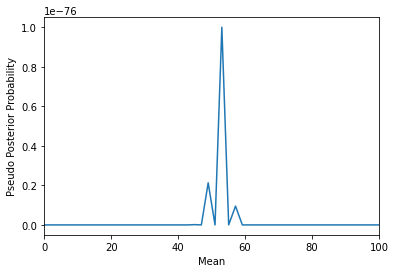

In [52]:
posterior_plot = plt.subplot(1,1,1)
posterior_plot.set_xlim(MU_MIN, MU_MAX)
posterior_plot.plot(mean_estimates, likelihoods * prior)
posterior_plot.set_xlabel("Mean")
posterior_plot.set_ylabel("Pseudo Posterior Probability")
print("Population Mean estimate: " + str(mean_estimates[np.argmax(likelihoods * prior)]))
plt.show()

Not bad! I solved the problem of picking appropriate parameters for the prior distribution by selecting a random value for $\mu'$ within the range of the training set, and then setting $\sigma'$ to be some random value equal 5-10% of the mean. Lets try adjusting the population parameters a bit so that the data set is more spread out, this should negatively effect our estimate.

Population Mean estimate: 53.06122448979592


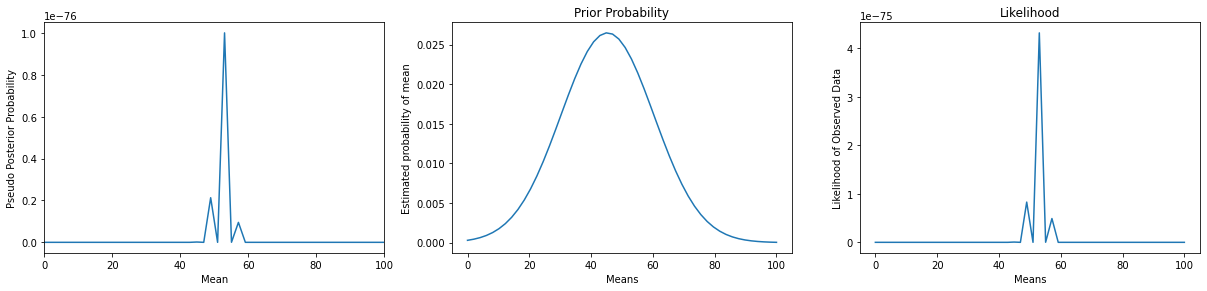

In [51]:
GROUND_TRUTH_MEAN = 50
GROUND_TRUTH_VARIANCE = 25
MU_MIN = 0
MU_MAX = 100
mean_estimates, random_samples, prior, likelihoods = execute_bayesian_inference(GROUND_TRUTH_MEAN,
                                                                                GROUND_TRUTH_VARIANCE,
                                                                                MU_MIN,
                                                                                MU_MAX,
                                                                                50)
prior_plot = plt.subplot(1,3,2)
prior_plot.set_title("Prior Probability")
prior_plot.set_xlabel("Means")
prior_plot.set_ylabel("Estimated probability of mean")
prior_plot.plot(mean_estimates, prior)

likelihood_plot = plt.subplot(1,3,3)
likelihood_plot.set_title("Likelihood")
likelihood_plot.set_xlabel("Means")
likelihood_plot.set_ylabel("Likelihood of Observed Data")
likelihood_plot.plot(mean_estimates, likelihoods)

posterior_plot = plt.subplot(1,3,1)
posterior_plot.set_xlim(MU_MIN, MU_MAX)
posterior_plot.plot(mean_estimates, likelihoods * prior)
posterior_plot.set_xlabel("Mean")
posterior_plot.set_ylabel("Pseudo Posterior Probability")

print("Population Mean estimate: " + str(mean_estimates[np.argmax(likelihoods * prior)]))
plt.subplots_adjust(bottom=0.1, right=2.8, top=0.9)
plt.show()

The estimate became more inaccurate because our prior became more inaccurate as we increased the population variance. However if the number of points in our training set is increased, this effect will be minimized.

c:\users\adib\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in double_scalars


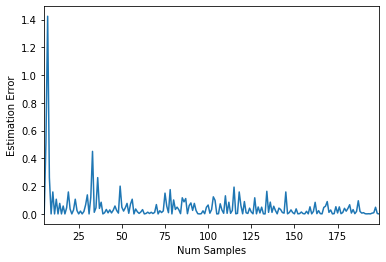

In [41]:
GROUND_TRUTH_MEAN = 50
GROUND_TRUTH_VARIANCE = 25
MU_MIN = 0
MU_MAX = 100
NUM_SAMPLES_RANGE = list(range(5, 200))
estimates = []
for num_samples in NUM_SAMPLES_RANGE:
    mean_estimates, random_samples, prior, likelihoods = execute_bayesian_inference(GROUND_TRUTH_MEAN,
                                                                                GROUND_TRUTH_VARIANCE,
                                                                                MU_MIN,
                                                                                MU_MAX,
                                                                                num_samples)
    posterior = likelihoods * prior
    estimates.append(mean_estimates[np.argmax(posterior)])

estimates = np.array(estimates)
error = (abs(estimates - GROUND_TRUTH_MEAN)**2) / estimates.size

error_plot = plt.subplot(1,1,1)
error_plot.set_xlim(np.min(NUM_SAMPLES_RANGE), np.max(NUM_SAMPLES_RANGE))
error_plot.plot(NUM_SAMPLES_RANGE, error)
error_plot.set_xlabel("Num Samples")
error_plot.set_ylabel("Estimation Error")
plt.show()


While maximimum likelihood estimation had confidence intervals here we can just look at the cumulative distribution of the posterior probability to figure out what values are captured within our desired probability range. The pseudo posterior probability that I used to quickly generate a mean estimate above isn't a true probability distribution because I've omitted the $P(Data)$ term in the Bayes theorem equation.

We need to generate some constant term $P(data) = c$ such that

$$
\begin{aligned}
\int{\frac{P(\theta|Data)}{c}} &= 1\\
c = \int{P(\theta|Data)}
\end{aligned}
$$

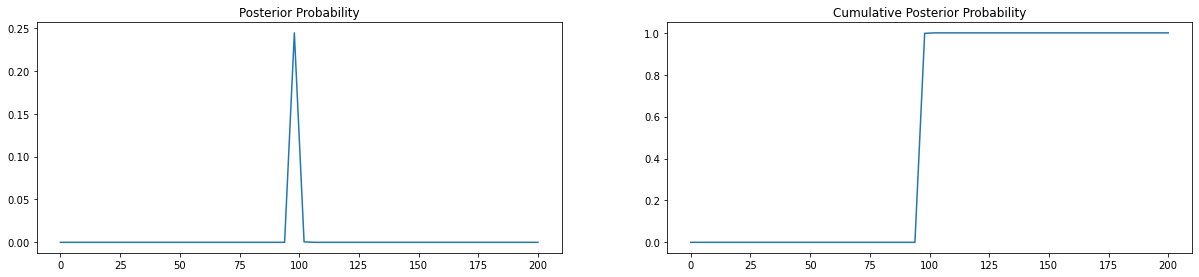

In [46]:
GROUND_TRUTH_MEAN = 100
GROUND_TRUTH_VARIANCE = 50
MU_MIN = 0
MU_MAX = 200
mean_estimates, random_samples, prior, likelihoods = execute_bayesian_inference(GROUND_TRUTH_MEAN,
                                                                                GROUND_TRUTH_VARIANCE,
                                                                                MU_MIN,
                                                                                MU_MAX,
                                                                                50)
pseudo_posterior = likelihoods * prior
dx = mean_estimates[1] - mean_estimates[0]
c = np.sum(pseudo_posterior) * dx
posterior = pseudo_posterior / c
cumulative_posterior = np.cumsum(posterior) * dx

posterior_plot = plt.subplot(121)
posterior_plot.plot(mean_estimates, posterior)
posterior_plot.set_title("Posterior Probability")

posterior_cdf_plot = plt.subplot(122)
posterior_cdf_plot.set_title("Cumulative Posterior Probability")
posterior_cdf_plot.plot(mean_estimates, cumulative_posterior)
plt.subplots_adjust(bottom=0.1, right=2.8, top=0.9)
plt.show()

Now the posterior probability is a true probability distribution and it can be used to provide the level of certainty of a range of values for the estimated mean. Suppose we want to find the range such that we have a 95% probability of the population mean being contained within it.

In [45]:
print(cumulative_posterior)
lower_bound_index = np.where(cumulative_posterior >= 0.025)[0][0]
lower_mean = (mean_estimates[lower_bound_index] + mean_estimates[lower_bound_index - 1]) / 2
upper_bound_index = np.where(cumulative_posterior <= 0.925)[0][-1]
upper_mean = (mean_estimates[upper_bound_index + 1] + mean_estimates[upper_bound_index]) / 2
print(f"Mean estimate with 95% confidence [{lower_mean},{upper_mean}]")

[1.56381046e-232 1.56381046e-232 1.56381046e-232 2.82941247e-041
 2.82941247e-041 7.07732450e-030 2.72832703e-027 2.22494763e-022
 2.22496892e-022 1.85790650e-013 1.85790650e-013 2.89254155e-004
 9.99388932e-001 9.99900678e-001 9.99999994e-001 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000]
Mean estimate with 95% confidence [95.83333333333334,95.83333333333334]
